#1. Model


In [1]:
from re import X
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    DLinear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            self.Linear_Decoder = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Decoder.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Decoder = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

# 2. Đọc dữ liệu

In [2]:
import pandas as pd
import torch
from datetime import datetime, timedelta
# Đọc dữ liệu từ drive
from google.colab import drive
drive.mount('/content/drive')
# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/drive/MyDrive/Ky_2_nam_3/DA/bnb.csv')

Mounted at /content/drive


In [3]:
# Chuyển dữ liệu thời gian
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
# # Đảo ngược lại dữ liệu

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335
...,...,...,...,...,...,...,...
1914,2024-05-27,599.825928,613.388184,599.700745,603.526428,603.526428,1691663828
1915,2024-05-28,603.526428,604.985107,593.716187,601.213257,601.213257,1852329404
1916,2024-05-29,601.213257,602.931519,592.966614,594.972046,594.972046,1642696946
1917,2024-05-30,594.972534,601.665039,586.557678,595.026794,595.026794,1737524745


#3. Chia tỉ lệ 6:2:2

In [6]:
# Chia tỉ lệ
# Lấy dữ liệu cần phân tích
time_series_Close = df['Close']


# numeric_columns = ['Close', 'Open', 'High', 'Low']
numeric_columns = ['Close']

# Chuyển các giá trị số thành tensor
numeric_data = df[numeric_columns].values.astype(np.float32)

# Mở rộng chiều để phù hợp với đầu vào của mô hình
numeric_data = np.expand_dims(numeric_data, axis=0)

# Tỉ lệ 6:2:2
# Kích thước tập dữ liệu (6:2:2)
train_size = int(0.6 * len(time_series_Close))
test_size = int(0.2 * len(time_series_Close))
val_size = int(len(time_series_Close) - train_size - test_size)
# Giá trị tập từ liệu (6:2:2)
train_data = time_series_Close[:train_size]
test_data = time_series_Close[train_size:train_size + test_size]
val_data = time_series_Close[-val_size:]
# Giá trị tensor
input_data_train = torch.tensor(numeric_data[:, :train_size, :])
input_data_test = torch.tensor(numeric_data[:, train_size:train_size + test_size])
input_data_val = torch.tensor(numeric_data[:,-val_size:,])

# In ra để kiểm tra kích thước của các tensor
print("Ti lệ 6:2:2")
print("Kích thước tập huấn luyện:", input_data_train.shape)
print("Kích thước tập test:", input_data_test.shape)
print("Kích thước tập val:", input_data_val.shape)

Ti lệ 6:2:2
Kích thước tập huấn luyện: torch.Size([1, 1151, 1])
Kích thước tập test: torch.Size([1, 383, 1])
Kích thước tập val: torch.Size([1, 385, 1])


In [28]:
# Lấy dữ liệu Date cần phân tích để dự bảo DL trên tập test và train
time_series_Date = df['Date']

# Tỉ lệ 6:2:2
# Kích thước tập dữ liệu (7:2:1)
train_date_size = int(0.6 * len(time_series_Date))
test_date_size = int(0.2 * len(time_series_Date))
val_date_size = int(len(time_series_Date) - train_date_size - test_date_size)
# Giá trị tập từ liệu (7:2:1)
train_date_data = time_series_Date[:train_date_size]
test_date_data = time_series_Date[train_date_size:train_date_size + test_date_size]
val_date_data = time_series_Date[-val_date_size:]

first_date_Date = test_date_data.min()
first_date_Date_2 = test_date_data.max()

print(first_date_Date)
print(first_date_Date_2)


2022-04-25 00:00:00
2023-05-12 00:00:00


In [8]:
# Chuyển các giá trị số thành tensor
# numeric_columns = ['Price', 'Open', 'High', 'Low']
numeric_columns = ['Close']

numeric_data = df[numeric_columns].values.astype(np.float32)
numeric_data = np.expand_dims(numeric_data, axis=0)
input_data = torch.tensor(numeric_data)

2.1 Dự đoán dữ liệu 7:2:1

In [22]:
# Khởi tạo cấu hình cho model
# Dự báo dựa trên tập train
class Configs:
    def __init__(self):
        self.seq_len = len(train_data)  # Độ dài chuỗi thời gian đầu vào
        self.pred_len = len(train_data)  # Độ dài dự đoán
        self.individual = False  # Có sử dụng các kênh cá nhân hay không
        self.enc_in = 1  # Số lượng kênh đầu vào (tương ứng với số cột của dữ liệu)

configs = Configs()

# Khởi tạo model
model_train = Model(configs)

In [21]:
# Khởi tạo cấu hình cho model
# Dự báo dựa trên tập train
class Configs:
    def __init__(self):
        self.seq_len = len(test_data)  # Độ dài chuỗi thời gian đầu vào
        self.pred_len = len(test_data)  # Độ dài dự đoán
        self.individual = False  # Có sử dụng các kênh cá nhân hay không
        self.enc_in = 1  # Số lượng kênh đầu vào (tương ứng với số cột của dữ liệu)

configs = Configs()

# Khởi tạo model
model_test = Model(configs)

In [23]:
# model_test
model_train

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=1151, out_features=1151, bias=True)
  (Linear_Trend): Linear(in_features=1151, out_features=1151, bias=True)
  (Linear_Decoder): Linear(in_features=1151, out_features=1151, bias=True)
)

In [24]:
# DL 30
import torch.optim as optim

# Xác định hàm mất mát và trình tối ưu hóa
criterion = nn.MSELoss()
optimizer = optim.Adam(model_train.parameters(), lr=0.001)  # Có thể điều chỉnh lr theo yêu cầu

# Huấn luyện mô hình
num_epochs = 100  # Số lượng epoch
for epoch in range(num_epochs):
    model_train.train()  # Chuyển sang chế độ huấn luyện
    optimizer.zero_grad()  # Đặt gradient về 0

    # Feedforward
    outputs = model_train(input_data_train)

    # Tính toán loss
    loss = criterion(outputs, input_data_train)  # So sánh đầu ra với đầu vào

    # Backpropagation
    loss.backward()  # Tính toán gradient
    optimizer.step()  # Cập nhật trọng số

    # In ra loss sau mỗi epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')





Epoch [1/100], Loss: 41644.3320
Epoch [2/100], Loss: 7429.3770
Epoch [3/100], Loss: 15181.6182
Epoch [4/100], Loss: 13205.5781
Epoch [5/100], Loss: 9082.7676
Epoch [6/100], Loss: 9349.7705
Epoch [7/100], Loss: 9928.1143
Epoch [8/100], Loss: 7174.8428
Epoch [9/100], Loss: 3781.1016
Epoch [10/100], Loss: 2977.1826
Epoch [11/100], Loss: 4527.3438
Epoch [12/100], Loss: 5607.6680
Epoch [13/100], Loss: 4757.7891
Epoch [14/100], Loss: 3116.8684
Epoch [15/100], Loss: 2321.6440
Epoch [16/100], Loss: 2588.6357
Epoch [17/100], Loss: 2839.7034
Epoch [18/100], Loss: 2342.6899
Epoch [19/100], Loss: 1552.4572
Epoch [20/100], Loss: 1296.2367
Epoch [21/100], Loss: 1669.9412
Epoch [22/100], Loss: 1984.6527
Epoch [23/100], Loss: 1696.7029
Epoch [24/100], Loss: 1051.6554
Epoch [25/100], Loss: 681.6898
Epoch [26/100], Loss: 808.1150
Epoch [27/100], Loss: 1054.0419
Epoch [28/100], Loss: 1000.8132
Epoch [29/100], Loss: 697.5844
Epoch [30/100], Loss: 498.8469
Epoch [31/100], Loss: 555.5696
Epoch [32/100], Los

In [25]:
# Dự báo cho 30 ngày kế tiếp
# predicted_dates = pd.date_range(start=first_date_Date_2 + pd.DateOffset(days=1), periods=len(predicted_values))
# # Chuyển sang chế độ đánh giá
model_train.eval()
# Không cần tính gradient trong quá trình dự báo
with torch.no_grad():
    input_data_future = input_data_train.clone()  # Tạo một bản sao của dữ liệu đầu vào để cập nhật dự báo
    predicted = []  # Danh sách dự báo cho các ngày tiếp theo
    for i in range(test_size):  # Dự báo cho 30 ngày tiếp theo
        # Dự báo cho ngày hiện tại
        output = model_train(input_data_future)
        # Lưu dự báo của ngày hiện tại
        predicted.append(output[:, -1, :])  # Lấy dự báo cho ngày cuối cùng trong chuỗi thời gian
        # Cập nhật dữ liệu đầu vào cho ngày tiếp theo
        input_data_future = torch.cat([input_data_future[:, :, 1:], output], dim=2)

    # In ra dự báo cho 30 ngày tiếp theo
    print("Predicted Output for the next 30 days:")
    for i in range(test_size):
        # In ra ngày tương ứng với dự báo
        print(f"Day {i+1}: {first_date_Date + pd.DateOffset(days=i+1)} - Predicted: {predicted[i][0]}")


Predicted Output for the next 30 days:
Day 1: 2022-04-26 00:00:00 - Predicted: tensor([398.0172])
Day 2: 2022-04-27 00:00:00 - Predicted: tensor([398.0886])
Day 3: 2022-04-28 00:00:00 - Predicted: tensor([398.1441])
Day 4: 2022-04-29 00:00:00 - Predicted: tensor([398.1988])
Day 5: 2022-04-30 00:00:00 - Predicted: tensor([398.2534])
Day 6: 2022-05-01 00:00:00 - Predicted: tensor([398.3080])
Day 7: 2022-05-02 00:00:00 - Predicted: tensor([398.3626])
Day 8: 2022-05-03 00:00:00 - Predicted: tensor([398.4172])
Day 9: 2022-05-04 00:00:00 - Predicted: tensor([398.4719])
Day 10: 2022-05-05 00:00:00 - Predicted: tensor([398.5265])
Day 11: 2022-05-06 00:00:00 - Predicted: tensor([398.5811])
Day 12: 2022-05-07 00:00:00 - Predicted: tensor([398.6358])
Day 13: 2022-05-08 00:00:00 - Predicted: tensor([398.6905])
Day 14: 2022-05-09 00:00:00 - Predicted: tensor([398.7451])
Day 15: 2022-05-10 00:00:00 - Predicted: tensor([398.7998])
Day 16: 2022-05-11 00:00:00 - Predicted: tensor([398.8545])
Day 17: 20

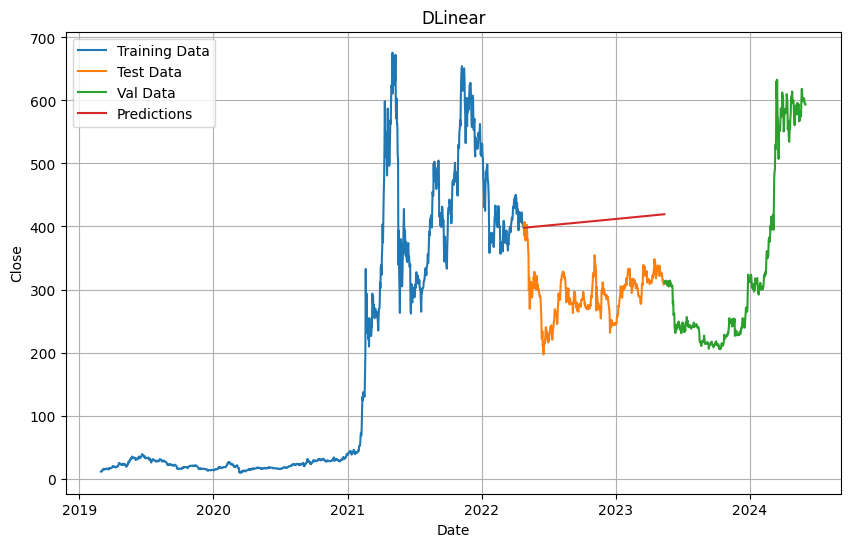

In [29]:
# DL 30 NGÀY
import matplotlib.pyplot as plt
# Chuyển dữ liệu dự báo từ tensor về numpy array
predicted_values = [pred[0].numpy() for pred in predicted]

# Chuyển đổi dữ liệu gốc từ tensor về numpy array
original_values = input_data[0, :, :].numpy()


# #
# last_date = df['Date'].max()
predicted_dates = pd.date_range(start=first_date_Date + pd.DateOffset(days=1), periods=len(predicted_values))

# Tạo mảng chứa ngày gốc
original_dates = df['Date'].values

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

plt.plot(train_date_data, train_data, label='Training Data')

plt.plot(test_date_data, test_data, label='Test Data')
plt.plot(val_date_data, val_data, label='Val Data')
plt.plot(predicted_dates, predicted_values, label='Predictions')

plt.xlabel('Date')
plt.ylabel('Close')
plt.title('DLinear')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
# DL 451
import torch.optim as optim

# Xác định hàm mất mát và trình tối ưu hóa
criterion = nn.MSELoss()
optimizer = optim.Adam(model_test.parameters(), lr=0.001)  # Có thể điều chỉnh lr theo yêu cầu

# Huấn luyện mô hình
num_epochs = 100  # Số lượng epoch
for epoch in range(num_epochs):
    model_test.train()  # Chuyển sang chế độ huấn luyện
    optimizer.zero_grad()  # Đặt gradient về 0

    # Feedforward
    outputs = model_test(input_data_test)

    # Tính toán loss
    loss = criterion(outputs, input_data_test)  # So sánh đầu ra với đầu vào

    # Backpropagation
    loss.backward()  # Tính toán gradient
    optimizer.step()  # Cập nhật trọng số

    # In ra loss sau mỗi epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1265.0955
Epoch [2/100], Loss: 8368.1748
Epoch [3/100], Loss: 1334.2057
Epoch [4/100], Loss: 1784.5791
Epoch [5/100], Loss: 4482.1904
Epoch [6/100], Loss: 3178.3560
Epoch [7/100], Loss: 771.1182
Epoch [8/100], Loss: 362.7312
Epoch [9/100], Loss: 1681.9607
Epoch [10/100], Loss: 2351.8379
Epoch [11/100], Loss: 1575.5068
Epoch [12/100], Loss: 497.9519
Epoch [13/100], Loss: 259.6761
Epoch [14/100], Loss: 779.7539
Epoch [15/100], Loss: 1181.0015
Epoch [16/100], Loss: 986.2225
Epoch [17/100], Loss: 506.2343
Epoch [18/100], Loss: 256.2340
Epoch [19/100], Loss: 353.2552
Epoch [20/100], Loss: 533.8480
Epoch [21/100], Loss: 551.1013
Epoch [22/100], Loss: 410.1522
Epoch [23/100], Loss: 265.0470
Epoch [24/100], Loss: 213.5871
Epoch [25/100], Loss: 238.5896
Epoch [26/100], Loss: 273.0523
Epoch [27/100], Loss: 267.9649
Epoch [28/100], Loss: 217.0847
Epoch [29/100], Loss: 153.9317
Epoch [30/100], Loss: 123.4227
Epoch [31/100], Loss: 136.8035
Epoch [32/100], Loss: 157.7280
Epoch [

In [31]:
# Dự báo cho 451 ngày kế tiếp
# # Chuyển sang chế độ đánh giá
model_test.eval()

# Không cần tính gradient trong quá trình dự báo
with torch.no_grad():
    input_data_future = input_data_test.clone()  # Tạo một bản sao của dữ liệu đầu vào để cập nhật dự báo
    predicted = []  # Danh sách dự báo cho các ngày tiếp theo
    for i in range(test_size):  # Dự báo cho 30 ngày tiếp theo
        # Dự báo cho ngày hiện tại
        output = model_test(input_data_future)
        # Lưu dự báo của ngày hiện tại
        predicted.append(output[:, -1, :])  # Lấy dự báo cho ngày cuối cùng trong chuỗi thời gian
        # Cập nhật dữ liệu đầu vào cho ngày tiếp theo
        input_data_future = torch.cat([input_data_future[:, :, 1:], output], dim=2)

    # In ra dự báo cho 30 ngày tiếp theo
    print("Predicted Output for the next 451 days:")
    for i in range(test_size):
        # In ra ngày tương ứng với dự báo
        print(f"Day {i+1}: {first_date_Date + pd.DateOffset(days=i+1)} - Predicted: {predicted[i][0]}")

Predicted Output for the next 451 days:
Day 1: 2022-04-26 00:00:00 - Predicted: tensor([309.0793])
Day 2: 2022-04-27 00:00:00 - Predicted: tensor([309.0632])
Day 3: 2022-04-28 00:00:00 - Predicted: tensor([309.0456])
Day 4: 2022-04-29 00:00:00 - Predicted: tensor([309.0279])
Day 5: 2022-04-30 00:00:00 - Predicted: tensor([309.0102])
Day 6: 2022-05-01 00:00:00 - Predicted: tensor([308.9925])
Day 7: 2022-05-02 00:00:00 - Predicted: tensor([308.9748])
Day 8: 2022-05-03 00:00:00 - Predicted: tensor([308.9572])
Day 9: 2022-05-04 00:00:00 - Predicted: tensor([308.9395])
Day 10: 2022-05-05 00:00:00 - Predicted: tensor([308.9218])
Day 11: 2022-05-06 00:00:00 - Predicted: tensor([308.9041])
Day 12: 2022-05-07 00:00:00 - Predicted: tensor([308.8865])
Day 13: 2022-05-08 00:00:00 - Predicted: tensor([308.8688])
Day 14: 2022-05-09 00:00:00 - Predicted: tensor([308.8511])
Day 15: 2022-05-10 00:00:00 - Predicted: tensor([308.8335])
Day 16: 2022-05-11 00:00:00 - Predicted: tensor([308.8158])
Day 17: 2

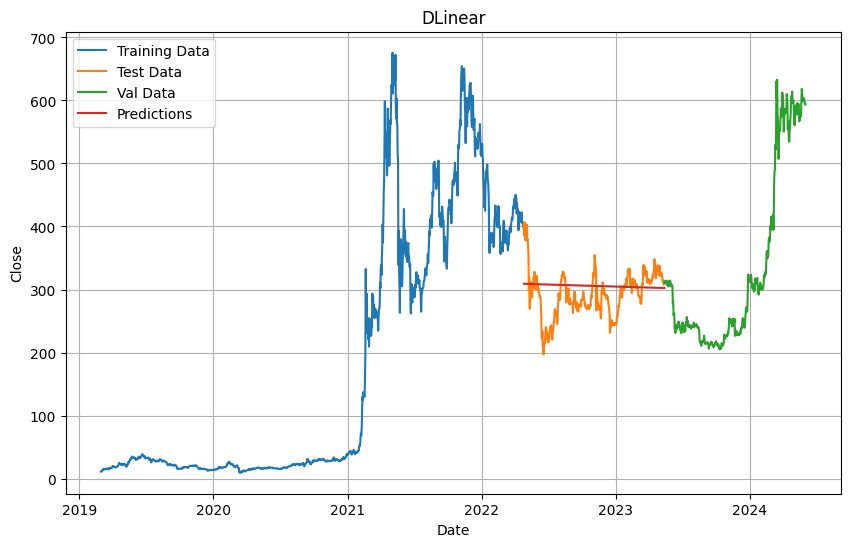

In [32]:
# dl 451 NGÀY
import matplotlib.pyplot as plt
# Chuyển dữ liệu dự báo từ tensor về numpy array
predicted_values = [pred[0].numpy() for pred in predicted]

# Chuyển đổi dữ liệu gốc từ tensor về numpy array
original_values = input_data[0, :, :].numpy()

#
predicted_dates = pd.date_range(start=first_date_Date + pd.DateOffset(days=1), periods=len(predicted_values))

# Tạo mảng chứa ngày gốc
original_dates = df['Date'].values

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

plt.plot(train_date_data, train_data, label='Training Data')
plt.plot(test_date_data, test_data, label='Test Data')
plt.plot(val_date_data, val_data, label='Val Data')
plt.plot(predicted_dates, predicted_values, label='Predictions')


plt.xlabel('Date')
plt.ylabel('Close')
plt.title('DLinear')
plt.legend()
plt.grid(True)
plt.show()